# Entrega Final
---

- **Autores**: Amalia Martín y Carlos Toro

## Objetivos

El objetivo de esta practica es implementar todo lo aprendido a lo largo de este módulo, para ello necesitaremos diseñar e implementar un sistema automático que:
- Entrene, evalúe y compare distintos modelos de clasificación binaria
- Seleccione el mejor modelo según una métrica principal, además de ofrecer una visión de
  otras secundarias.
- Automatice el flujo completo desde los datos hasta la inferencia.


## Importamos las librerías

In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score,
    mean_squared_error, mean_absolute_error, r2_score
)
from sklearn.tree import (
    DecisionTreeClassifier
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics


### Definimos las funciones auxiliares

In [228]:
# Calculamos las métricas de evaluación
def calcular_metricas_evaluacion(y_prediccion: np.ndarray, y_real: np.ndarray, verbose: bool = True):
    """Calcula las métricas de evaluación para un modelo de regresión.
    
    Calcula cuatro métricas comunes para evaluar modelos de regresión: MSE (Error Cuadrático Medio),
    RMSE (Raíz del Error Cuadrático Medio), MAE (Error Absoluto Medio) y R² (Coeficiente de determinación).
    Opcionalmente imprime los resultados en un formato legible.
    
    Args:
        y_prediccion (np.ndarray): Valores predichos por el modelo.
        y_real (np.ndarray): Valores reales observados.
        verbose (bool, optional): Si es True, imprime las métricas calculadas. Por defecto es True.
    
    Returns:
        tuple[float, float, float, float]: Una tupla con cuatro valores en el siguiente orden:
            - mse: Error cuadrático medio.
            - rmse: Raíz del error cuadrático medio.
            - mae: Error absoluto medio.
            - r2: Coeficiente de determinación.
    
    Example:
        >>> mse, rmse, mae, r2 = calcular_metricas_evaluacion(modelo.predict(X_test), y_test)
        >>> print(f"R²: {r2:.4f}")
    """
    
    mse = mean_squared_error(y_real, y_prediccion)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_real, y_prediccion)
    r2 = r2_score(y_real, y_prediccion)

    if verbose:
        print("\nEvaluación del modelo:")
        print(f"MSE (Error cuadrático medio): {mse:.4f}")
        print(f"RMSE (Raíz del error cuadrático medio): {rmse:.4f}")
        print(f"MAE (Error absoluto medio): {mae:.4f}")
        print(f"R² (Coeficiente de determinación): {r2:.4f}")
        print(f"El modelo explica aproximadamente el {r2:.2%} de la varianza")
    
    return mse, rmse, mae, r2

In [229]:
# Definir función para construir el modelo
def keras_neural_network(input_shape, learning_rate, dropout_rate):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[metrics.Recall(name='recall')]
    )
    return model

## Carga y procesamiento de datos

In [230]:
PATH_DIRECTORIO_DATOS = "../data"
PATH_DATASET_HOTEL = f"{PATH_DIRECTORIO_DATOS}/dataset_hotel_preprocessed.csv"

Cargamos los datos procesamos previamente en el EDA

In [231]:
# Cargamos los datos
df_hotel_preprocessed = pd.read_csv(PATH_DATASET_HOTEL)

In [232]:
# Lista de los nombres de las columnas
target_column = 'is_canceled'
lista_columnas_independientes = df_hotel_preprocessed.drop(columns = target_column).columns.to_list()
print(lista_columnas_independientes)

['lead_time', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'reserved_room_type', 'assigned_room_type', 'booking_changes', 'deposit_type', 'days_in_waiting_list', 'customer_type', 'adr', 'total_of_special_requests']


In [233]:
X_hotel = df_hotel_preprocessed.drop(columns=target_column)
y_hotel = df_hotel_preprocessed[target_column]

# Hacemos esto par apoder aplicar el GridSearch ya que no podemos usarlo con str
X_hotel = pd.get_dummies(X_hotel, drop_first=True)

## Entrenamiento de modelos

In [234]:
results = []

###  MODELO 1: REGRESIÓN LOGÍSTICA

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.5, stratify=y_hotel, random_state=42)

In [236]:
# Verificamos el ratio
print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True))

print("\nDistribución de clases en el conjunto de entrenamiento:")
print(y_test.value_counts(normalize=True))


Distribución de clases en el conjunto de entrenamiento:
is_canceled
0    0.725165
1    0.274835
Name: proportion, dtype: float64

Distribución de clases en el conjunto de entrenamiento:
is_canceled
0    0.725142
1    0.274858
Name: proportion, dtype: float64


#### Entrenamiento del modelo

In [222]:
#traemos los valores nulos de cada variable
valores_nulos = X_hotel.isnull().sum()
print("\nValores nulos por columna:")   
print(valores_nulos[valores_nulos > 0])



Valores nulos por columna:
children         4
agent        16340
company     112593
dtype: int64


In [237]:
# Entrenamos un modelo usando GridSearchCV para encontrar los mejores hiperparámetros
dict_parametros = {
    'C' : [0.01,0.1,1,10,100],
    'solver': ['liblinear']
}

modelo_rl = LogisticRegression(max_iter=200, random_state=42)
modelo_rl_cv = GridSearchCV(modelo_rl, dict_parametros, cv = 5, scoring="f1")
modelo_rl_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=200, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear']},
             scoring='f1')

In [238]:
print(f"Mejores hiperparámetros encontrados: {modelo_rl_cv.best_params_}")
print(f"Mejor score obtenido: {modelo_rl_cv.best_score_:.2%}")

Mejores hiperparámetros encontrados: {'C': 100, 'solver': 'liblinear'}
Mejor score obtenido: 36.36%


In [239]:
modelo_rl = LogisticRegression(**modelo_rl_cv.best_params_, max_iter=500, random_state=42)
modelo_rl.fit(X_train, y_train)

LogisticRegression(C=100, max_iter=500, random_state=42, solver='liblinear')

#### Evaluación del modelo

In [240]:
# Predicción sobre el conjunto de test
y_pred = modelo_rl.predict(X_test)
y_proba = modelo_rl.predict_proba(X_test)[:, 1]

In [241]:
# Mostramos las primeras 5 etiquetas reales, las probabilidades de pertenencia a la clase positiva y las predicciones
print(f"Primeras 5 etiquetas reales: {y_test.iloc[:5].values}")
print(f"Primeras 5 probabilidades: {y_proba[:5]}")
print(f"Primeras 5 predicciones: {y_pred[:5]}")

Primeras 5 etiquetas reales: [0 0 0 1 0]
Primeras 5 probabilidades: [0.05959828 0.44907756 0.25228503 0.30253462 0.31970768]
Primeras 5 predicciones: [0 0 0 0 0]


In [242]:
# Asegurar que sean enteros
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
# Obtención de las métricas de evaluación la que más nos interesa en F1-Score
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

# Añadimos los resultados al conjunto de resultados
results.append({
    "Modelo": "Regresión Logística",
    "Accuracy": acc,
    "Precisión": prec,
    "Recall": rec,
    "F1-Score": f1,
    "AUC": auc
})

#imprimimos como df el último resultado añadido
print(pd.DataFrame(results[-1], index=[0]))

                Modelo  Accuracy  Precisión    Recall  F1-Score       AUC
0  Regresión Logística  0.758263   0.655338  0.254183  0.366293  0.756223


In [243]:
# Gracias a la función classification_report podemos obtener un reporte detallado de las métricas de evaluación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85     31221
           1       0.66      0.25      0.37     11834

    accuracy                           0.76     43055
   macro avg       0.71      0.60      0.61     43055
weighted avg       0.74      0.76      0.72     43055



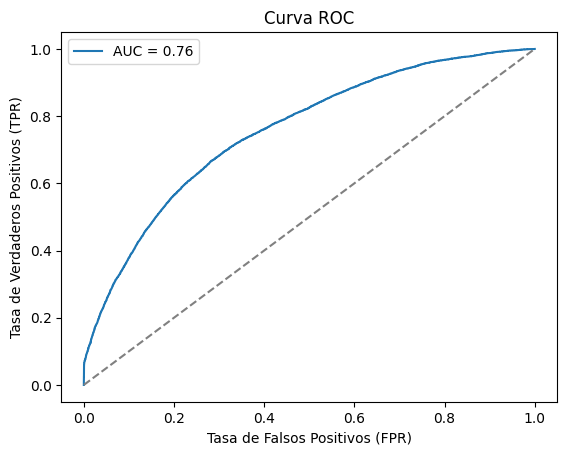

In [244]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

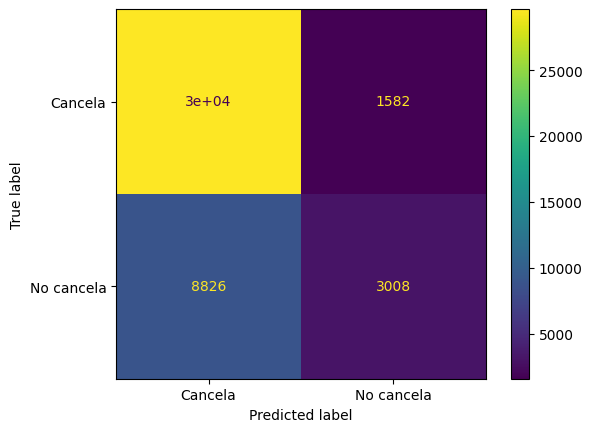

In [245]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

###  MODELO 2: ÁRBOL DE DECISIÓN

#### Entrenamiento del modelo

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42)

modelo_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
modelo_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

#### Evaluación del modelo

In [247]:
# Hacemos predicciones sobre el conjunto de test
y_pred = modelo_rl.predict(X_test)
y_proba = modelo_rl.predict_proba(X_test)[:, 1]

In [248]:
# Parseamos a int la varioble
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

# Añadimos los resultados al conjunto de resultados
results.append({
    "Modelo": "Árbol de Decisión",
    "Accuracy": acc,
    "Precisión": prec,
    "Recall": rec,
    "F1-Score": f1,
    "AUC": auc
})

#imprimimos como df el último resultado añadido
print(pd.DataFrame(results[-1], index=[0]))

              Modelo  Accuracy  Precisión    Recall  F1-Score       AUC
0  Árbol de Decisión  0.756707   0.638412  0.252869  0.362253  0.757487


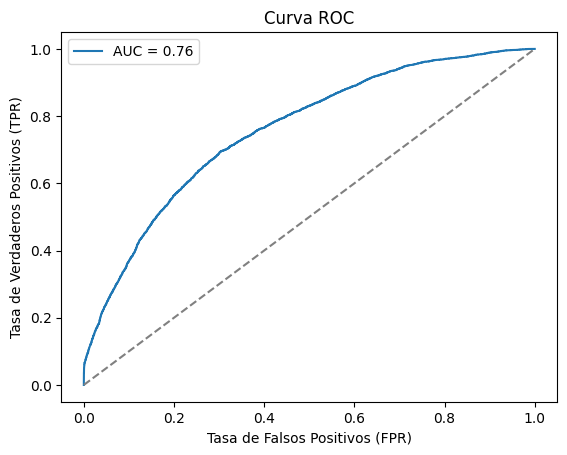

In [249]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

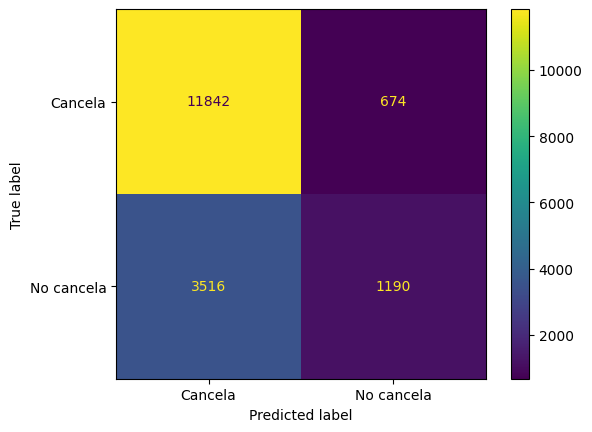

In [250]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

### MODELO 3: RANDOM FOREST

In [251]:
# Preparación de los datos para el entrenamiento del modelo
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42)

#### Entrenamiento del modelo

In [252]:
# Entrenamiento de un modelo de RandomForest Classifier
modelo_rfc = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Evaluación del modelo

In [253]:
# Hacemos predicciones sobre el conjunto de test
y_pred = modelo_rl.predict(X_test)
y_proba = modelo_rl.predict_proba(X_test)[:, 1]

In [254]:
#Cambiamos le tipo de las varaibles para la grafica
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

# Añadimos los resultados al conjunto de resultados
results.append({
    "Modelo": "Random Forest Classifier",
    "Accuracy": acc,
    "Precisión": prec,
    "Recall": rec,
    "F1-Score": f1,
    "AUC": auc
})

#imprimimos como df el último resultado añadido
print(pd.DataFrame(results[-1], index=[0]))

                     Modelo  Accuracy  Precisión    Recall  F1-Score       AUC
0  Random Forest Classifier  0.756707   0.638412  0.252869  0.362253  0.757487


In [255]:
# Importancia de variables
col_importancia_rf = modelo_rfc.feature_importances_

df_hotel_preprocessed = pd.DataFrame({
    'variable': X_hotel.columns,
    'importancia': col_importancia_rf
}).sort_values(by= 'importancia', ascending= True).reset_index(drop=True)

#Visualización de la importancia de variables
fig= px.bar(
    df_hotel_preprocessed,
    x = 'importancia',
    y = 'variable',
    text='importancia',
    text_auto = ".3%",
    title = 'Importancia de las variables en el módelo Random Forest',
    labels={'x': 'Importnacia', 'y':'Variable'},
    width=700, height=500
)
fig.update_layout(xaxis_tickangle=45)
fig.show(renderer='iframe')

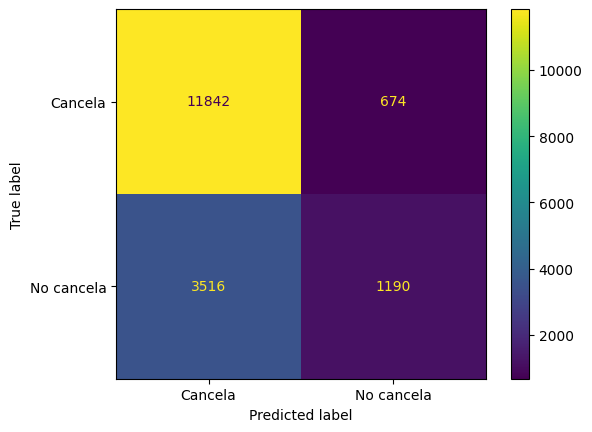

In [256]:
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

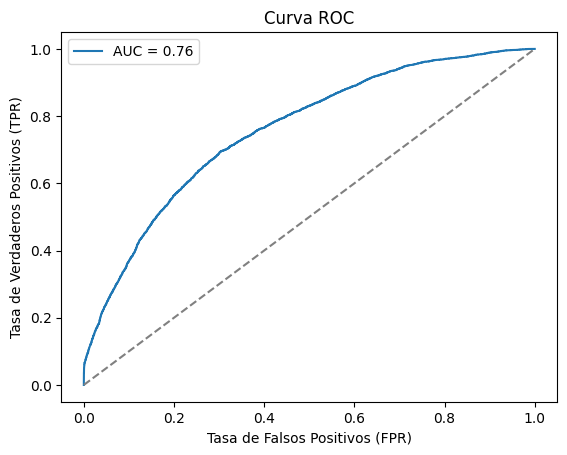

In [257]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

### MODELO 4: XGBOOST

In [258]:
X_hotel_encoded = pd.get_dummies(X_hotel)
# Preparación de los datos para el modelo de regresión lineal
X_train, X_test, y_train, y_test = train_test_split(X_hotel_encoded, y_hotel, test_size=0.2, random_state=42, stratify=y_hotel)

#### CLASIFICACIÓN

#### Entrenamiento del modelo

In [259]:
#Cambiamos le tipo de las varaibles para el modelo
X_train = X_train.astype(int)
y_train = y_train.astype(int)

# Entrenamiento de un modelo de RandomForest Regressor
modelo_xgbc = XGBClassifier(n_estimators=300, max_depth=3, learning_rate=0.1, eval_metric='logloss', random_state=42)
modelo_xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

#### Evaluciación del modelo

In [260]:
#Cambiamos le tipo de las varaibles para la grafica
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Hacemos predicciones sobre el conjunto de test
y_pred = modelo_xgbc.predict(X_test)
y_proba = modelo_xgbc.predict_proba(X_test)[:,1]

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

# Añadimos los resultados al conjunto de resultados
results.append({
    "Modelo": "XGBoost Classifier",
    "Accuracy": acc,
    "Precisión": prec,
    "Recall": rec,
    "F1-Score": f1,
    "AUC": auc
})

#imprimimos como df el último resultado añadido
print(pd.DataFrame(results[-1], index=[0]))

               Modelo  Accuracy  Precisión    Recall  F1-Score       AUC
0  XGBoost Classifier  0.783358   0.680606  0.398901  0.502997  0.801825


#### REGRESIÓN

#### Entrenamiento del modelo

In [261]:
#Entrenamiento para regresión
# Preparación de los datos para el modelo de regresión lineal
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42)

# Entrenamiento de un modelo de RandomForest Regressor
modelo_xgb = XGBRegressor(n_estimators=100, max_depth=3 , random_state=42)
modelo_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

#### Evaluciación del modelo

In [262]:
# Hacemos predicciones sobre el conjunto de test
y_pred = modelo_xgb.predict(X_test)
# Evaluamos el modelo usando las métricas de regresión
mse, rmse, mae, r2 = calcular_metricas_evaluacion(y_pred, y_test)


Evaluación del modelo:
MSE (Error cuadrático medio): 0.1524
RMSE (Raíz del error cuadrático medio): 0.3904
MAE (Error absoluto medio): 0.3146
R² (Coeficiente de determinación): 0.2326
El modelo explica aproximadamente el 23.26% de la varianza


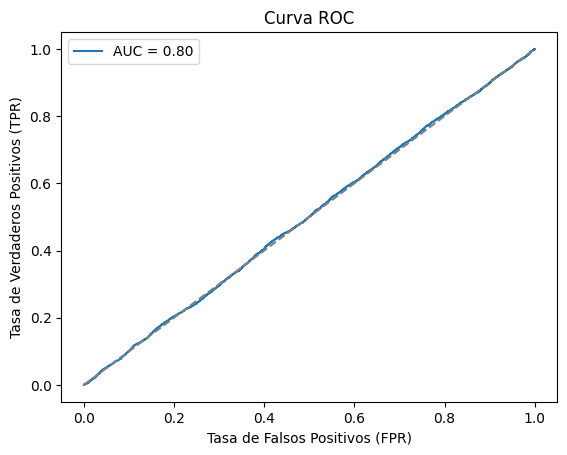

In [263]:
# tenemos que cambiar el tipo test a int
y_test = y_test.astype(int)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

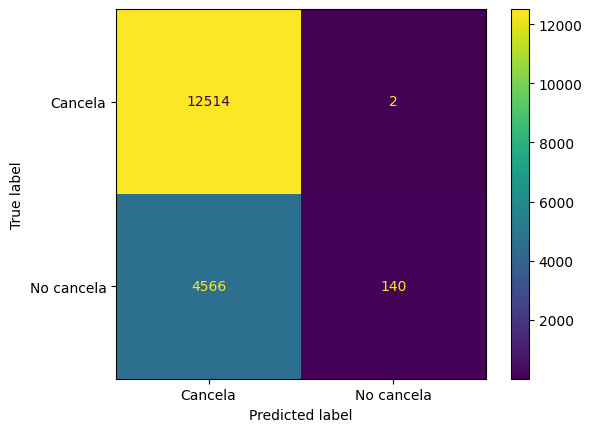

In [264]:
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)
# Mostramos la matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Cancela', 'No cancela'])
disp.plot()
plt.show()

### MODELO 5: RED NEURONAL MULTICAPA

In [265]:
# Preparación de los datos para la red neuronal multicapa
X_train, X_test, y_train, y_test = train_test_split(X_hotel, y_hotel, test_size=0.2, random_state=42, stratify=y_hotel)

In [266]:
#Definimos los hiperparámetros para el modelo de red neuronal
keras_params = {
    'learning_rate': [0.001, 0.01],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [32],
    'epochs': [10]
}

best_score = 0
best_model = None
best_params = {}

In [268]:
#Cambiamos le tipo de las varaibles para el modelo
X_train = X_train.astype(int)
y_train = y_train.astype(int)

In [269]:
# Escalamos los datos
scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train)
X_test_processed = scaler.transform(X_test)

#### Entrenamiento del modelo

In [270]:
print("Iniciando entrenamiento de la red neuronal multicapa...")
for lr in keras_params['learning_rate']:
    for dr in keras_params['dropout_rate']:
        print(f"\tlr = {lr} || dr = {dr}")
        model = keras_neural_network(
            input_shape=(X_train_processed.shape[1],),
            learning_rate=lr,
            dropout_rate=dr
        )

        history = model.fit(
            X_train_processed, y_train,
            batch_size=32,
            epochs=10,
            validation_split=0.2,
            verbose=0,
            callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
        )

        # Evaluar según el máximo recall de validación
        val_recall = max(history.history['val_recall'])
        if val_recall > best_score:
            best_score = val_recall
            best_model = model
            best_params = {'lr': lr, 'dropout_rate': dr}


Iniciando entrenamiento de la red neuronal multicapa...
	lr = 0.001 || dr = 0.2


C:\Users\Carlos\Documents\DL-ML\pontia_modulo_ml_alumnos\env-pontia-ml\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



	lr = 0.001 || dr = 0.3
	lr = 0.01 || dr = 0.2
	lr = 0.01 || dr = 0.3


#### Evaluciación del modelo

In [271]:
#Cambiamos le tipo de las varaibles para la grafica
y_test = y_test.astype(int)
y_pred = y_pred.astype(int)

# Hacemos predicciones sobre el conjunto de test
y_pred_prob = best_model.predict(X_test_processed).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

# Añadimos los resultados al conjunto de resultados
results.append({
    "Modelo": "Red Neuronal Multicapa",
    "Accuracy": acc,
    "Precisión": prec,
    "Recall": rec,
    "F1-Score": f1,
    "AUC": auc
})

#imprimimos como df el último resultado añadido
print(pd.DataFrame(results[-1], index=[0]))

539/539 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step
                   Modelo  Accuracy  Precisión    Recall  F1-Score       AUC
0  Red Neuronal Multicapa  0.782546    0.67129  0.409043  0.508337  0.801825


### EVALUACIÓN CONJUNTA

In [272]:
df_results = pd.DataFrame(results, columns=["Modelo", "Accuracy", "Precisión", "Recall", "F1-Score", "AUC"])
display(df_results)

,Modelo,Accuracy,Precisión,Recall,F1-Score,AUC
0,Regresión Logística,0.758263,0.655338,0.254183,0.366293,0.756223
1,Árbol de Decisión,0.756707,0.638412,0.252869,0.362253,0.757487
2,Random Forest Classifier,0.756707,0.638412,0.252869,0.362253,0.757487
3,XGBoost Classifier,0.783358,0.680606,0.398901,0.502997,0.801825
4,Red Neuronal Multicapa,0.782546,0.671290,0.409043,0.508337,0.801825


#### Guardamos las métricas calculadas para cargarlos posteriormente

In [273]:
# guardamos los datos en un csv
df_results.to_csv(f"{PATH_DIRECTORIO_DATOS}/resultados_modelos.csv", index=False)